# Normalization

**Import**

In [1]:
# from second tutorial notebook (Part02)
import scanpy as sc
import pandas as pd
import scvelo as scv
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import ipywidgets as widgets

# others
import re
import os

# first tutorial
import bbknn
import diffxpy.api as dxpy
import plotly.express as px

# Meritxell's
import anndata2ri

In [2]:
# Meritxell's normalization
# Activate the anndata2ri conversion between SingleCellExperiment and AnnData
anndata2ri.activate()

#Loading the rpy2 extension enables cell magic to be used
#This runs R code in jupyter notebook cells
%load_ext rpy2.ipython

sc.settings.verbosity = 3
#sc.logging.print_versions()

**Read anndata matrix**

In [3]:
path_out = f'/home/astridkd/testis_singlecell/Workspaces/adahl/birc-project-akd/data/mapping/GOR/adata/'

adata_out_mm = f'{path_out}/preproc_1_starsolo_multimap_gor.h5ad'

In [4]:
palette_dict = {"Elongated_spermatids":'#0173B2',"Round_spermatids":'#FF7C00',"Spermatocytes":"green","Spermatogonia":"red"}

In [5]:
# open saved data
adata = sc.read(adata_out_mm)

In [6]:
adata

AnnData object with n_obs × n_vars = 3772 × 22045
    obs: 'DATASET', 'batch', 'total_counts', 'n_genes_by_counts', 'percent_mito', 'prop_unspl', 'prop_spl', 'perc_MALAT1', 'n_genes', 'doublet_scores', 'predicted_doublets'
    var: 'gene_ids', 'feature_types', 'chromosome', 'n_cells'
    layers: 'raw_counts', 'spliced', 'unspliced'

In [7]:
cd '/home/astridkd/testis_singlecell/Workspaces/adahl/birc-project-akd/tutorial/'

/faststorage/project/testis_singlecell/Workspaces/adahl/birc-project-akd/tutorial


In [8]:
%run Scripts/pythonScripts.py

computing PCA
    with n_comps=50
    finished (0:00:06)


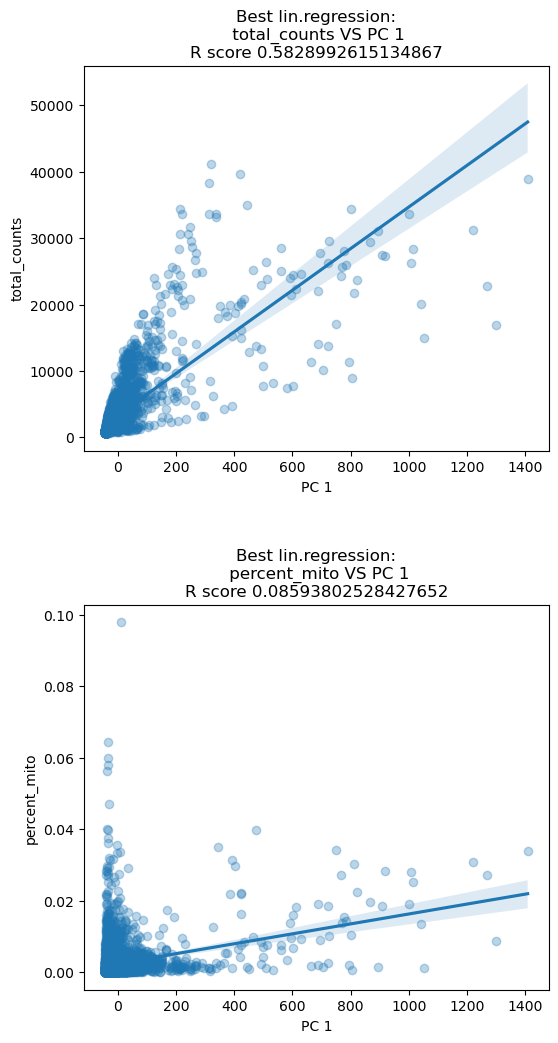

In [9]:
#from /home/astridkd/testis_singlecell/Workspaces/adahl/birc-project-akd/tutorial/Scripts/pythonScripts import dependentFeatures

#PCA on unnormalized data
sc.preprocessing.pca(adata, svd_solver='arpack', random_state=12345)
#Calculating correlations
dependentFeatures(adata=adata, obs_subset=['total_counts','percent_mito']) # plots the PC with the highest R2 to total counts and percent mito, respectively


The third biggest variation in the data at this point is explained by total UMI count. Normalizing with TPM should remove this bias.

In [10]:
adata

AnnData object with n_obs × n_vars = 3772 × 22045
    obs: 'DATASET', 'batch', 'total_counts', 'n_genes_by_counts', 'percent_mito', 'prop_unspl', 'prop_spl', 'perc_MALAT1', 'n_genes', 'doublet_scores', 'predicted_doublets'
    var: 'gene_ids', 'feature_types', 'chromosome', 'n_cells'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'raw_counts', 'spliced', 'unspliced'

In [11]:
adata.var_names

Index(['LOC100996442', 'LOC729737', 'LOC112268260', 'LOC100132287',
       'LOC100288069', 'LINC01409', 'LINC00115', 'LINC01128', 'LOC284600',
       'SAMD11',
       ...
       'COX2', 'ATP8', 'ATP6', 'COX3', 'ND3', 'ND4L', 'ND4', 'ND5', 'ND6',
       'CYTB'],
      dtype='object', length=22045)

In [12]:
rawMatrix = adata.X.todense().T
cells = adata.obs_names
genes = adata.var_names
dataset = np.array(adata.obs["DATASET"])

In [13]:
rawMatrix.shape

(22045, 3772)

In [14]:
%%R -i rawMatrix -i cells -i genes -i dataset -o norm_sct -o umi_corr -o genes_var

library(Seurat)
colnames(rawMatrix) <- cells
rownames(rawMatrix) <- genes
meta <- data.frame(DATASET = dataset)  # add batch as metadata
print(dim(rawMatrix))
seurat_df <- CreateSeuratObject(rawMatrix)
seurat_df <- AddMetaData(seurat_df, meta$DATASET, col.name = "DATASET")
# scTransform
seurat_df <- SCTransform(seurat_df, verbose = TRUE, variable.features.n = length(genes), vars.to.regress = c("DATASET"), return.only.var.genes=FALSE) # normalize data with Negative binomial regression
# Get matrix of residuals
norm_sct <- GetAssayData(seurat_df,assay="SCT",slot="scale.data") # assign normalized and scaled data (not 0 mean scaling)
umi_corr <- GetAssayData(seurat_df,assay="SCT",slot="counts")
genes_var <- rownames(seurat_df$SCT)


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

R[write to console]: Attaching SeuratObject



[1] 22045  3772


R[write to console]: Warning:
R[write to console]:  Feature names cannot have underscores ('_'), replacing with dashes ('-')

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Variance stabilizing transformation of count matrix of size 22045 by 3772

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 2000 genes, 3772 cells



  |======================================================================| 100%


R[write to console]: Found 6 outliers - those will be ignored in fitting/regularization step


R[write to console]: Second step: Get residuals using fitted parameters for 22045 genes



  |======================================================================| 100%


R[write to console]: Computing corrected count matrix for 22045 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 1.388496 mins

R[write to console]: Determine variable features

R[write to console]: Place corrected count matrix in counts slot

R[write to console]: Regressing out DATASET

  |                                                                            
  |                                                                      |   0%
  |                                                                            
  |                                                                      |   1%
  |                                                                            
  |=                                                                     |   1%
  |                                                                            
  |=                                                                     |   2%
  |                                                                        

In [15]:
norm_sct.shape

(22045, 3772)

In [16]:
# remove objects from R workspace that I will no longer need
# %%R
# rm(list = ls())

In [17]:
adata.var_names = ["-".join(x.split("_")) for x in adata.var_names] # change _ in gene names to - so it works in R code
adata = adata[:,np.array(genes_var)].copy() # only use genes ...
# creating SCT layers in anndata object
adata.layers["norm_sct"] = norm_sct.T
adata.layers["umi_corr"] = umi_corr.T

In [18]:
adata.X = adata.layers['norm_sct'].copy() # normalized and scaled matrix as default

In [19]:
sc.pp.pca(adata)

computing PCA
    with n_comps=50
    finished (0:00:20)


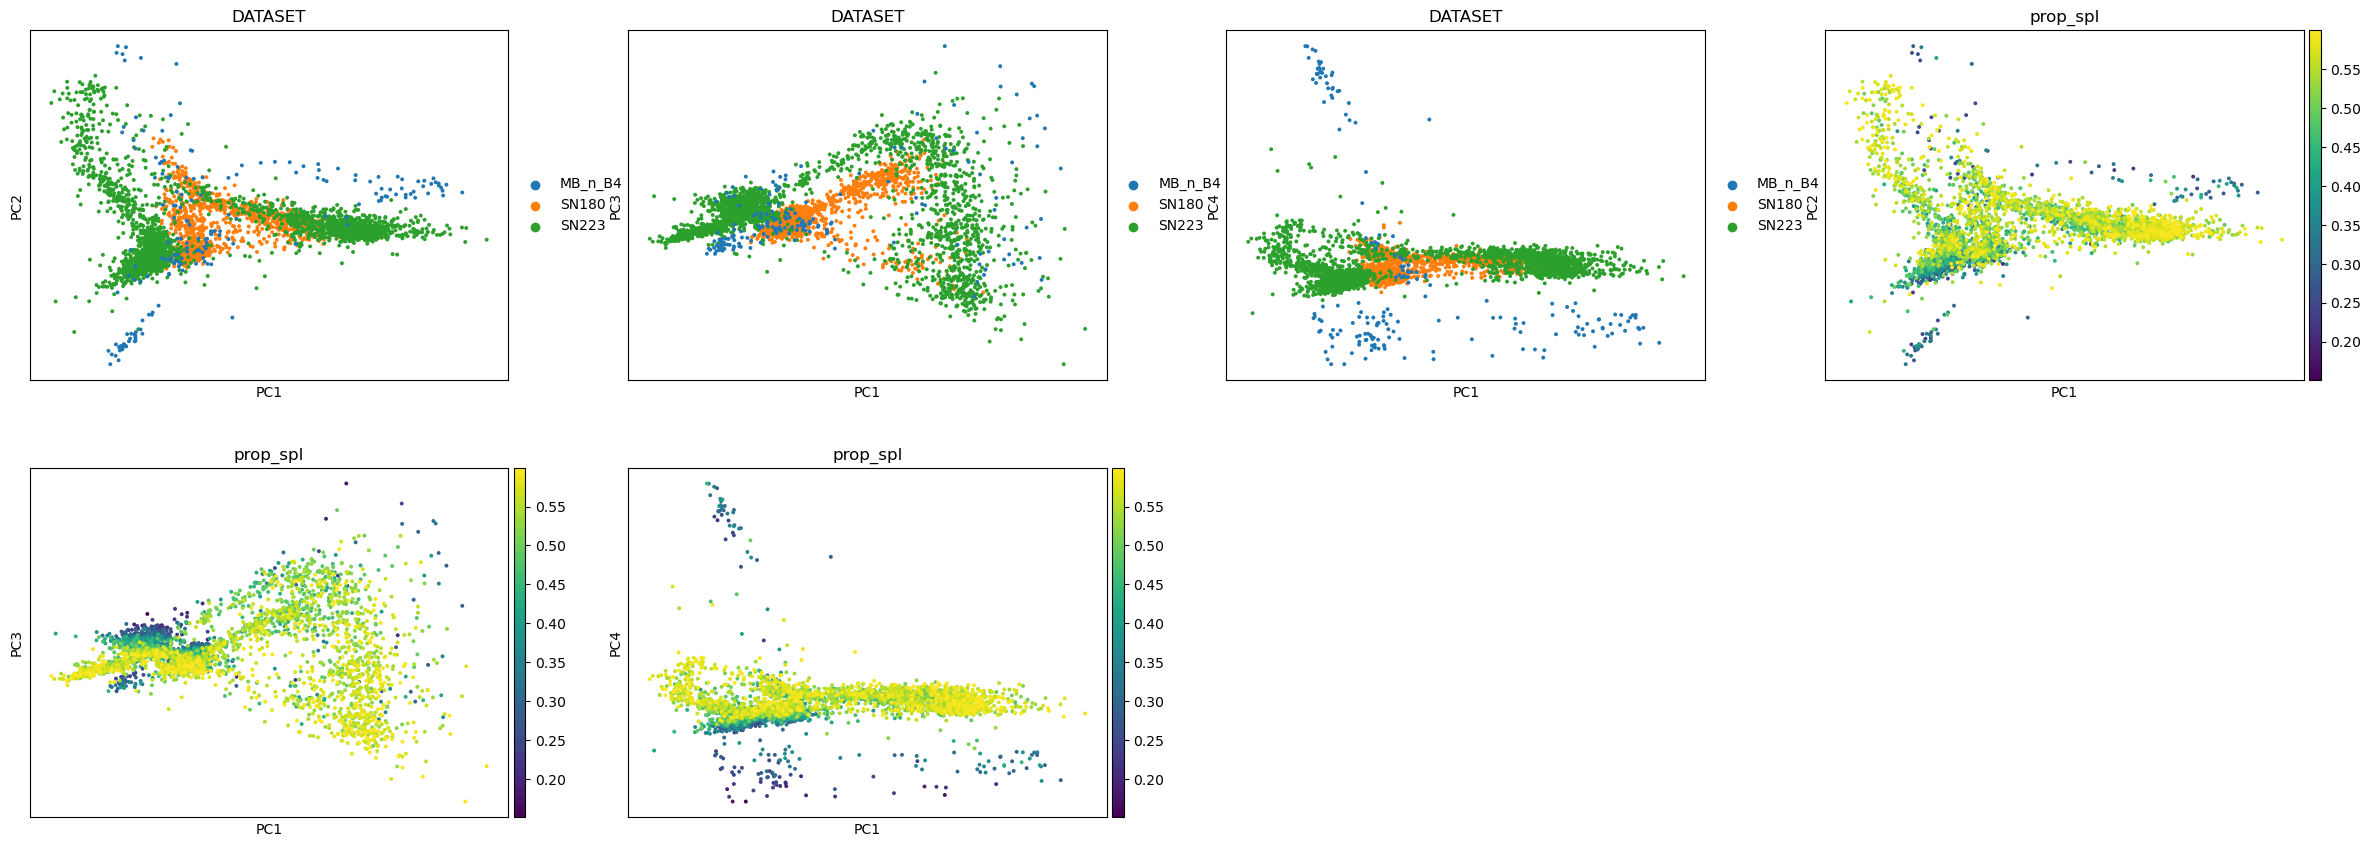

In [20]:
sc.pl.pca(adata, color=['DATASET','prop_spl'], components=['1,2','1,3','1,4'])

In [30]:
# most variable genes, True or False
sc.pp.highly_variable_genes(adata, n_top_genes=10000)

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [31]:
adata.layers

Layers with keys: raw_counts, spliced, unspliced, norm_sct, umi_corr

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:14)


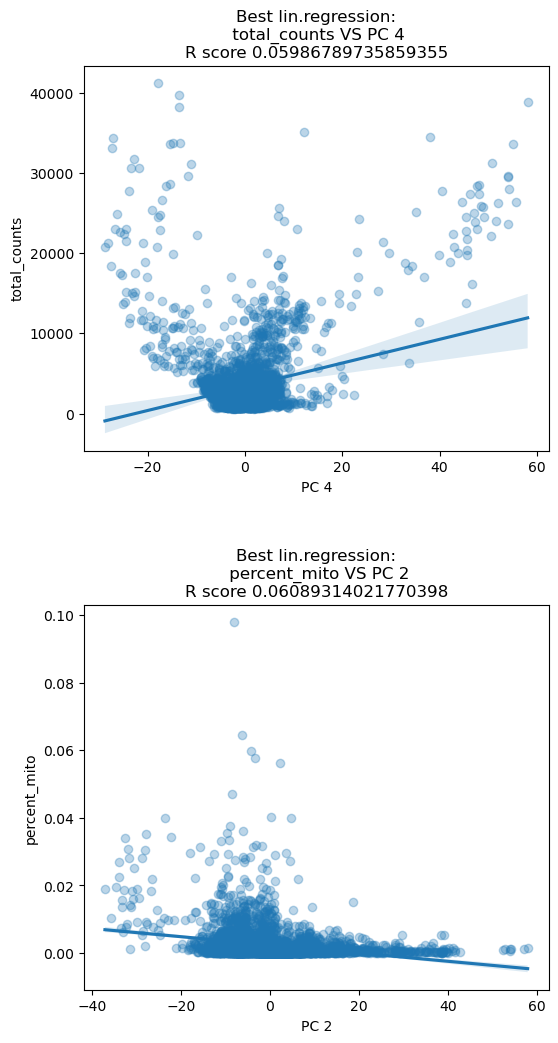

In [32]:
#PCA on normalized data
sc.preprocessing.pca(adata, svd_solver='arpack', random_state=12345)
#Calculating correlations
dependentFeatures(adata=adata, obs_subset=['total_counts','percent_mito'])

Now the correlation isn't strong.

Luckily the samples overlap, so they can be analyzed combined

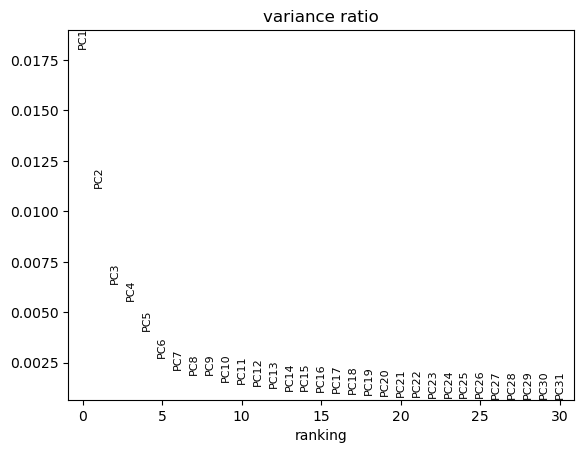

In [33]:
sc.plotting.pca_variance_ratio(adata) # small variance means it probably models noice in the data

Keep the PCs with the most variance, e.g. up to PC10

In [112]:
#sc.pp.neighbors(adata, n_pcs=15, random_state=12345) # use only for data with one single sample
bbknn.bbknn(adata, batch_key='DATASET', n_pcs=40, neighbors_within_batch=3) # increase neighbor number from 3 (within batch)

In [113]:
sc.tools.umap(adata, random_state=54321)

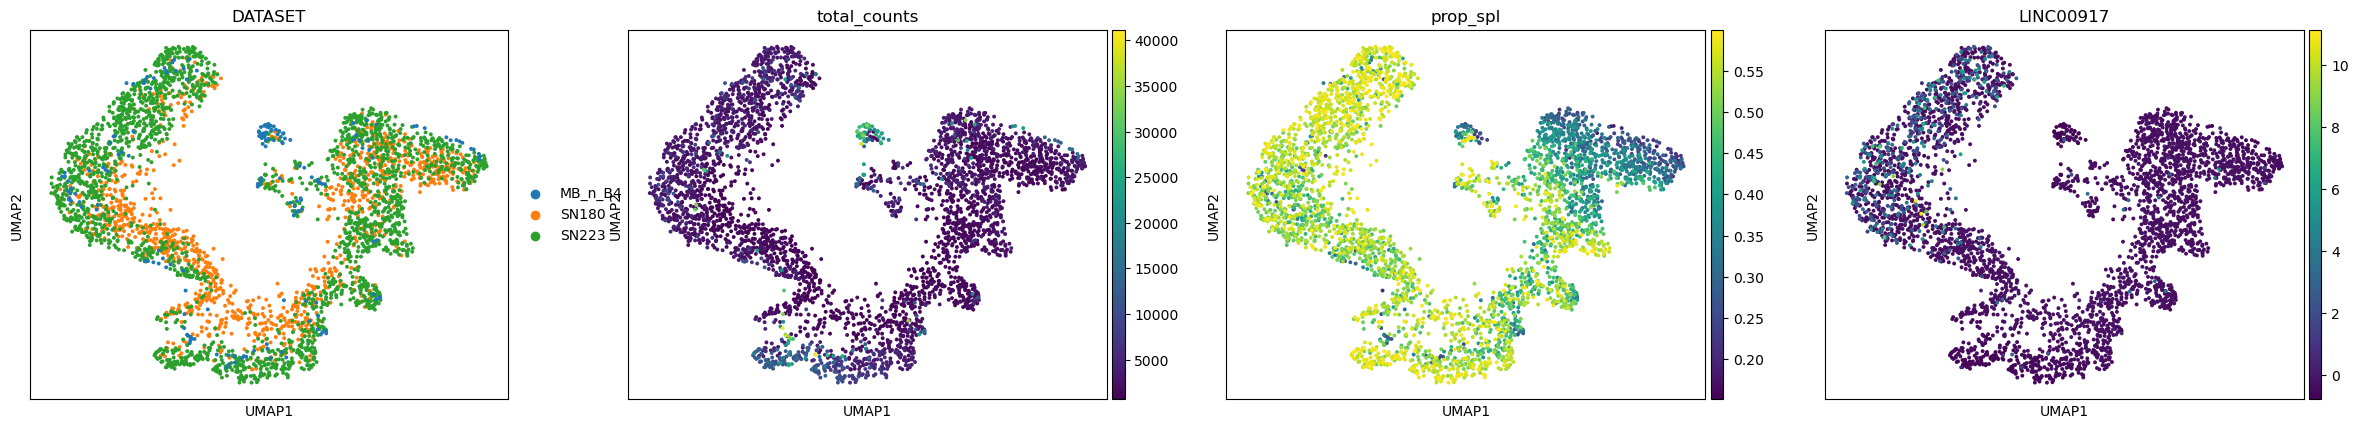

In [114]:
sc.plotting.umap(adata, color=['DATASET','total_counts','prop_spl','LINC00917'])

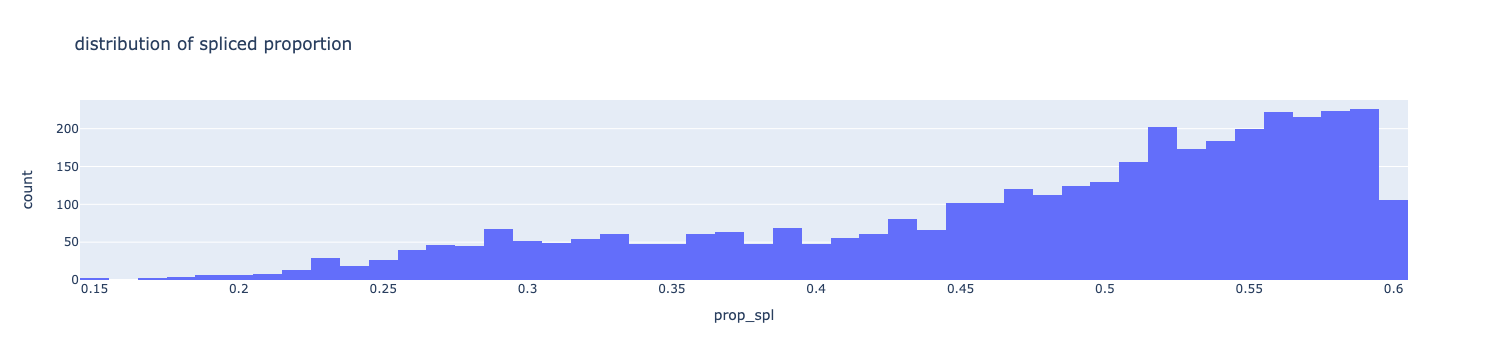

In [115]:
fig = px.histogram(adata.obs['prop_spl'], x='prop_spl', nbins=50,
                  title='distribution of spliced proportion')
fig.show()

In [116]:
adata

AnnData object with n_obs × n_vars = 3772 × 22045
    obs: 'DATASET', 'batch', 'total_counts', 'n_genes_by_counts', 'percent_mito', 'prop_unspl', 'prop_spl', 'perc_MALAT1', 'n_genes', 'doublet_scores', 'predicted_doublets'
    var: 'gene_ids', 'feature_types', 'chromosome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'pca', 'DATASET_colors', 'hvg', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'raw_counts', 'spliced', 'unspliced', 'norm_sct', 'umi_corr'
    obsp: 'distances', 'connectivities'

In [62]:
markers = dict() #make an empty dictionary
# Markers from the group google doc added
### SPERMATOCYTOGENESIS
markers['SpermatogoniaA'] = ['ID4','HMGA1','PIWIL4','UTF1','SLC22A2','FGFR3']
markers['SpermatogoniaB'] = ['MKI67','DMRT1','STRA8','ANP32B','SDF2L1','DMRT1','NANOS3'] # add markers for both?
markers['SpermatocytesI'] = ['MEIOB','PRSS50','SYCP1','TEX101','SPAG6','FTHL17','ART3','KCTD19','ASRGL1','LDHAL6B','LYAR','ZPBP2','ADAM2','CLGN','DDX25'] # general 'MYBL1','SYCP3','HORMAD1','SYNGR4', missing a few pachytene markers
markers['SpermatocytesII'] = ['PIWIL1','ACRV1','SPATA16','CLGN','UBE2T']
### SPERMIOGENESIS
markers['Round.Spt'] = ['SPATA9','SPAM1','DNAJB13','EFHB','LYZL6','PSD3','SLC16A7','TBC1D21','TMEM144'] # missing a few markers
markers['Elong.Spt'] = ['PRM1','PRM2','AGPAT2','AKAP1','BAG1','CST8','DNAJB7','DNAJB8','FNDC8','LELP1','RANGAP1','SPATA3','TSSK6','TXNDC2','TNP1','TP53TG5']
### SOMATIC CELLS
markers['Sertoli'] = ['CTSL','VIM','ACSL4','WT1','GAS6','BCAR1','DMRT1']
markers['Macroph'] = ['CD163','TYROBP']
markers['Leydig'] = ['ACTA2','CFD','IGF1','IGFBP5','CYP19A1','CYP17A1','INSL3']
markers['Endothelial'] = ['CD34']

In [63]:
# higher marker scores when only a few is considered and therefore more visible clusters
markers = dict() #make an empty dictionary
### SPERMATOCYTOGENESIS
markers['SpermatogoniaA'] = ['ID4','HMGA1']
markers['SpermatogoniaB'] = ['MKI67','DMRT1','STRA8'] 
markers['SpermatocytesI'] = ['MEIOB','PRSS50','SYCP1','TEX101']
markers['SpermatocytesII'] = ['PIWIL1','ACRV1','SPATA16','CLGN']
### SPERMIOGENESIS
markers['Round.Spt'] = ['SPATA9','SPAM1'] #Round spermatids
markers['Elong.Spt'] = ['PRM1','PRM2'] #Elongated spermatids
### SOMATIC CELLS
markers['Sertoli'] = ['CTSL', 'VIM']
markers['Macroph'] = ['CD163'] #'TYROBP' removed
markers['Leydig'] = ['CFD']
markers['Endothelial'] = ['CD34']

In [117]:
# markers in article and course mixed
markers = dict() #make an empty dictionary
#markers['SpermatogoniaB'] = ['MKI67','DMRT1','STRA8'] 
### SPERMATOCYTOGENESIS
markers['Undif. SG'] = ['ID4','HMGA1']
markers['Dif. SG'] = ['MKI67','DMRT1','STRA8'] 
markers['SC.I'] = ['MEIOB','PRSS50','SYCP1','TEX101']
markers['SC.II'] = ['PIWIL1','ACRV1','SPATA16','CLGN']
### SPERMIOGENESIS
markers['Early round SD'] = ['LRRIQ1'] #Round spermatids, Distinct #better than tutorial
markers['Late round SD'] = ['ACRV1','SPACA1'] #Round spermatids, Distinct #better than tutorial
markers['Elong SD'] = ['SPATA3','NRBP1','PRM1','GABBR2'] #Elongated spermatids #better than tutorial
### SOMATIC CELLS
markers['Sertoli'] = ['CLU'] # very distinct #better than tutorial
markers['Macroph'] = ['APOE','CD74']
markers['Leydig'] = ['STAR','CYP11A1']
markers['Endothelial'] = ['CD34'] #'TM4SF1' not expressed

In [118]:
markers_scores, adata = marker_score(markers, adata)

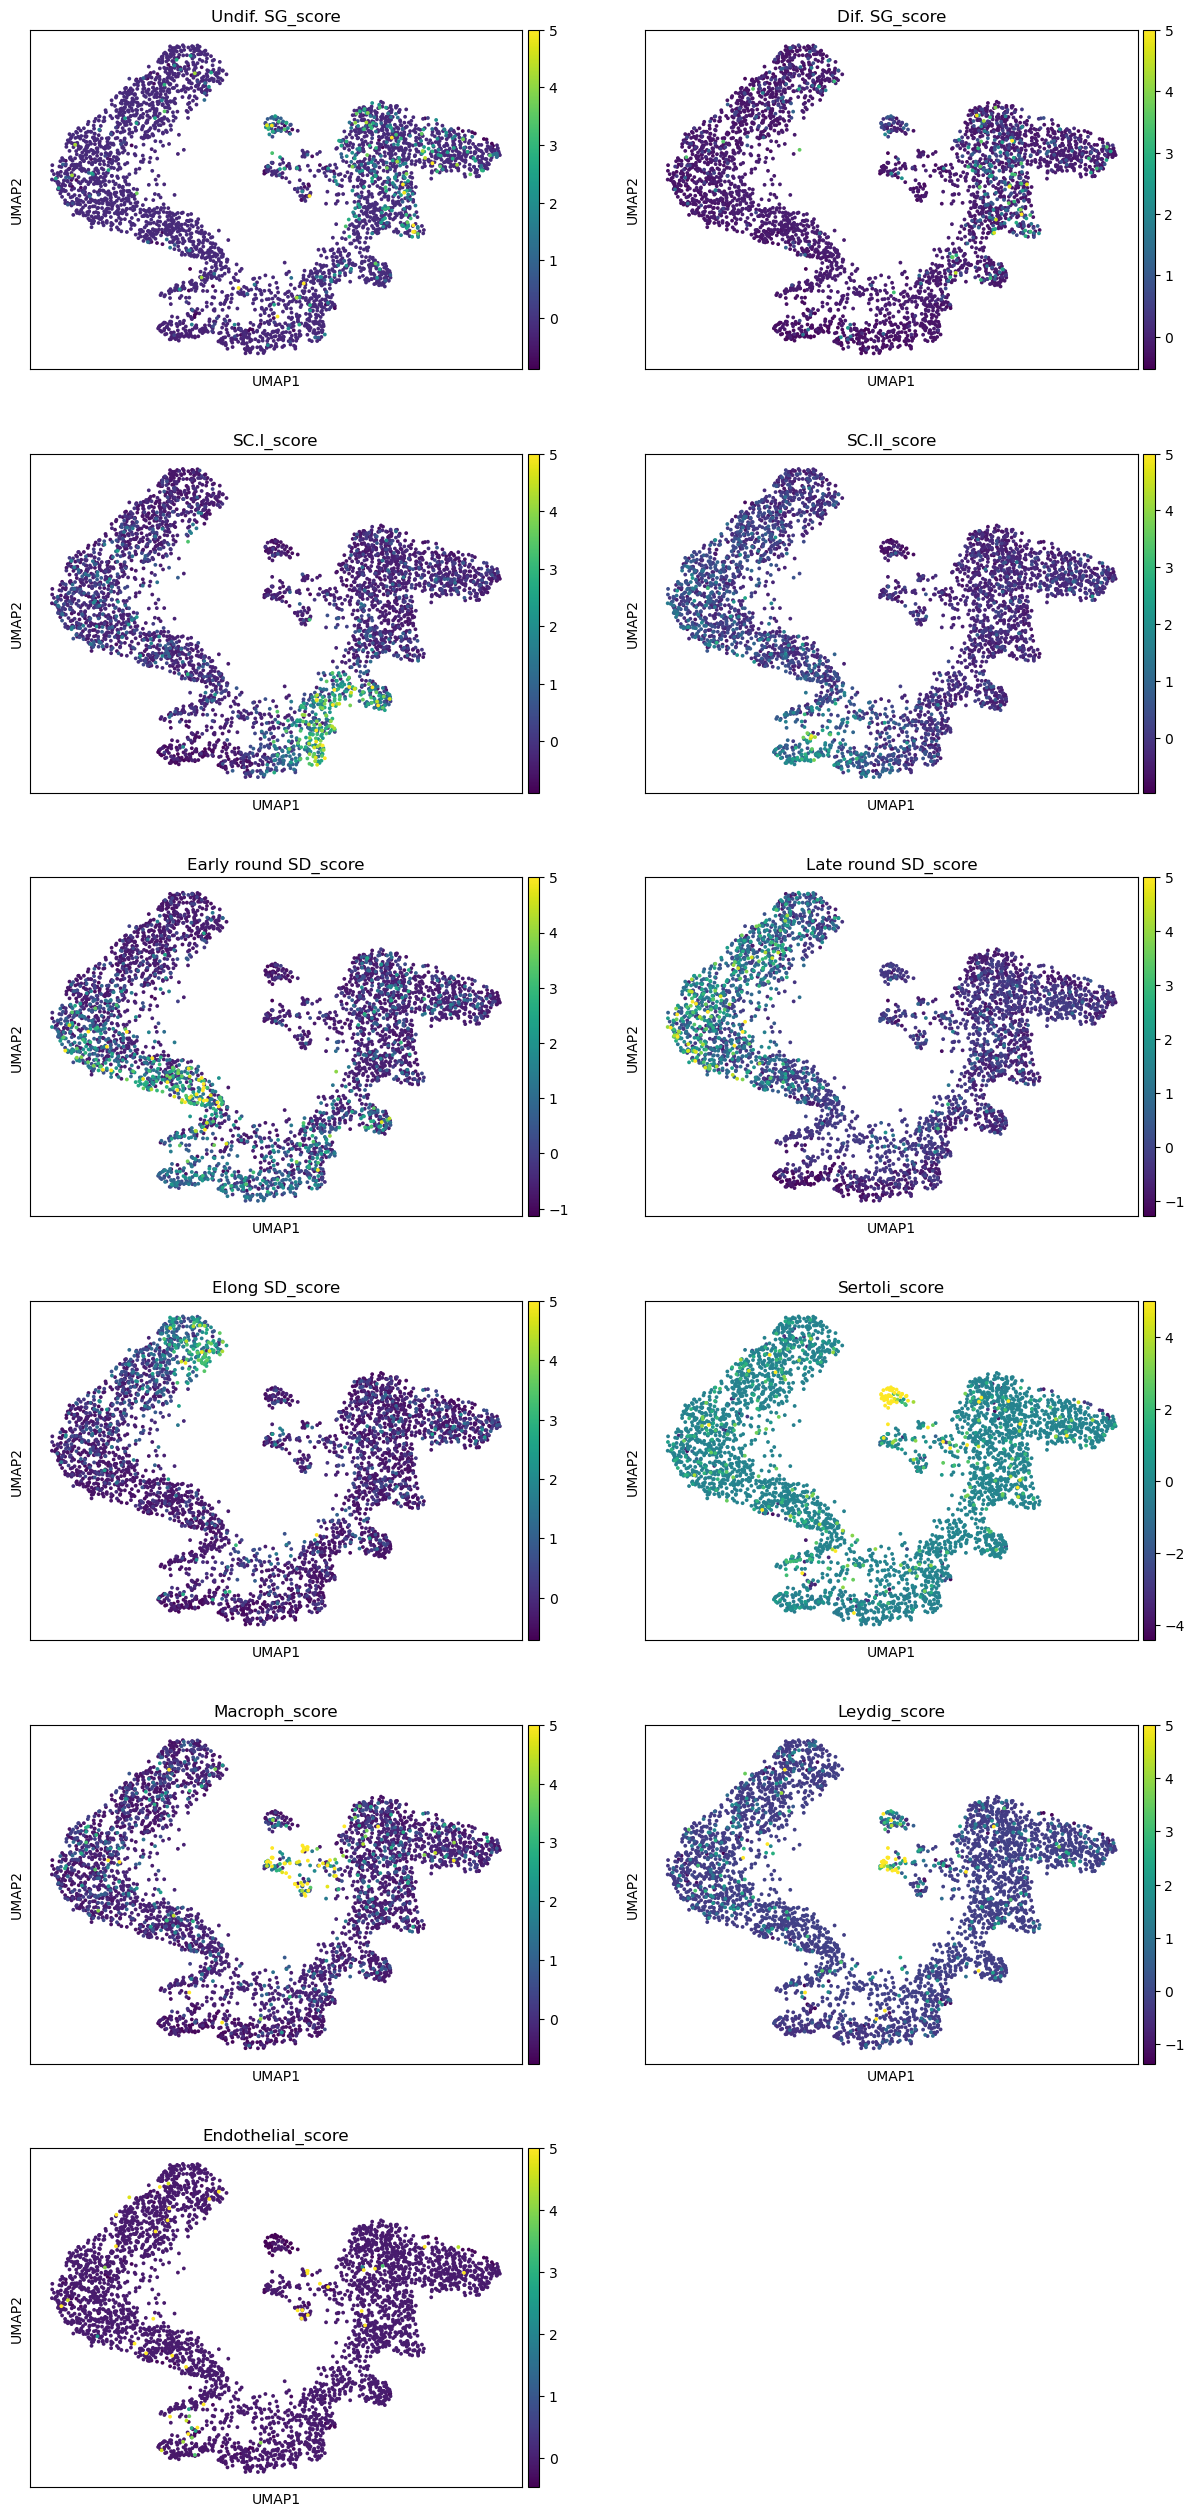

In [119]:
sc.plotting.umap(adata, color=markers_scores, components=['1,2'], ncols=2, vmax=5, s=30)

In [125]:
#leiden clustering at various resolutions
sc.tools.leiden(adata, resolution=0.5, random_state=12345, key_added='leiden_R.5')
sc.tools.leiden(adata, resolution=0.4, random_state=12345, key_added='leiden_R.4')
sc.tools.leiden(adata, resolution=0.3, random_state=12345, key_added='leiden_R.3')
sc.tools.leiden(adata, resolution=0.1, random_state=12345, key_added='leiden_R.1')

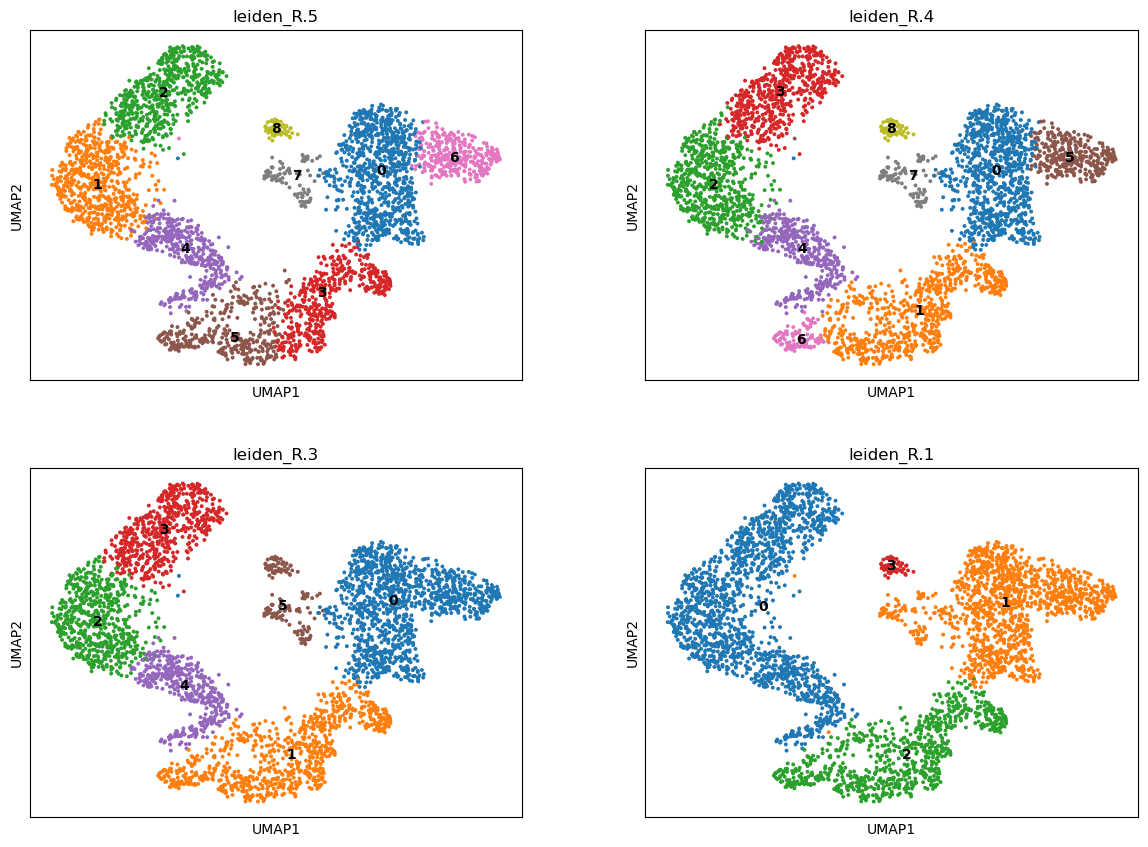

In [126]:
sc.plotting.umap(adata, color=['leiden_R.5','leiden_R.4','leiden_R.3','leiden_R.1'], legend_loc='on data', ncols=2)

In [16]:
adata.layers

Layers with keys: norm_sct, raw_counts, spliced, umi_corr, unspliced

In [127]:
adata

AnnData object with n_obs × n_vars = 3772 × 22045
    obs: 'DATASET', 'batch', 'total_counts', 'n_genes_by_counts', 'percent_mito', 'prop_unspl', 'prop_spl', 'perc_MALAT1', 'n_genes', 'doublet_scores', 'predicted_doublets', 'Undif. SG_score', 'Dif. SG_score', 'SC.I_score', 'SC.II_score', 'Early round SD_score', 'Late round SD_score', 'Elong SD_score', 'Sertoli_score', 'Macroph_score', 'Leydig_score', 'Endothelial_score', 'leiden_R.3', 'leiden_R.2', 'leiden_R.1', 'leiden_R.5', 'leiden_R.4'
    var: 'gene_ids', 'feature_types', 'chromosome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'pca', 'DATASET_colors', 'hvg', 'neighbors', 'umap', 'leiden', 'leiden_R.3_colors', 'leiden_R.2_colors', 'leiden_R.1_colors', 'leiden_R.5_colors', 'leiden_R.4_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'raw_counts', 'spliced', 'unspliced', 'norm_sct', 'umi_corr'
    obsp: 'distances', 'connectivities'

Comparing the Leiden clusters to the clusters represented by cell markers resolution 0,5 match the best

In [128]:
sc.tl.rank_genes_groups(adata, groupby='leiden_R.5', n_genes=50, key_added='DE_leiden') # diff.expressed genes in each cluster (t-test)

In [129]:
adata.uns['DE_leiden']

{'params': {'groupby': 'leiden_R.5',
  'reference': 'rest',
  'method': 't-test',
  'use_raw': False,
  'layer': None,
  'corr_method': 'benjamini-hochberg'},
 'names': rec.array([('amplicon-chrX-GAGE10/1/2A/13/12B/12C/12D/12E/12F/12G/12H/12J', 'FAM229A', 'LINC01000', 'SYCP1', 'OBSL1', 'C5orf58', 'SLC38A9', 'MALAT1', 'MIR202HG'),
            ('NF1', 'LOC730098', 'FAM229A', 'ZCWPW1', 'RBAKDN', 'COX7A2', 'NRG3', 'B2M', 'ERBB4'),
            ('ABCC1', 'CLDND2', 'C20orf144', 'SYCP3', 'RBAK-RBAKDN', 'GIHCG', 'GRIP1', 'TSHZ2', 'KIAA1217'),
            ('CALN1', 'DKKL1', 'TMEM191B', 'RAD51AP2', 'COX6C', 'ANKRD30A', 'NKAIN2', 'INSL3', 'CLU'),
            ('AUTS2', 'NELL1', 'PFN3', 'DMRTC2', 'SPINK2', 'FAM153A', 'CNTNAP2', 'APOE', 'MIR924HG'),
            ('MTUS2', 'CNBD1', 'LOC401357', 'LOC105373554', 'LOC730098', 'KRBOX1', 'LOC107984294', 'MIR99AHG', 'CARMIL1'),
            ('JMJD1C', 'COL25A1', 'PRM3', 'AGBL4', 'LOC105372835', 'STRBP', 'LINC02096', 'GSTA1', 'ABCA8'),
            ('LOC1053698

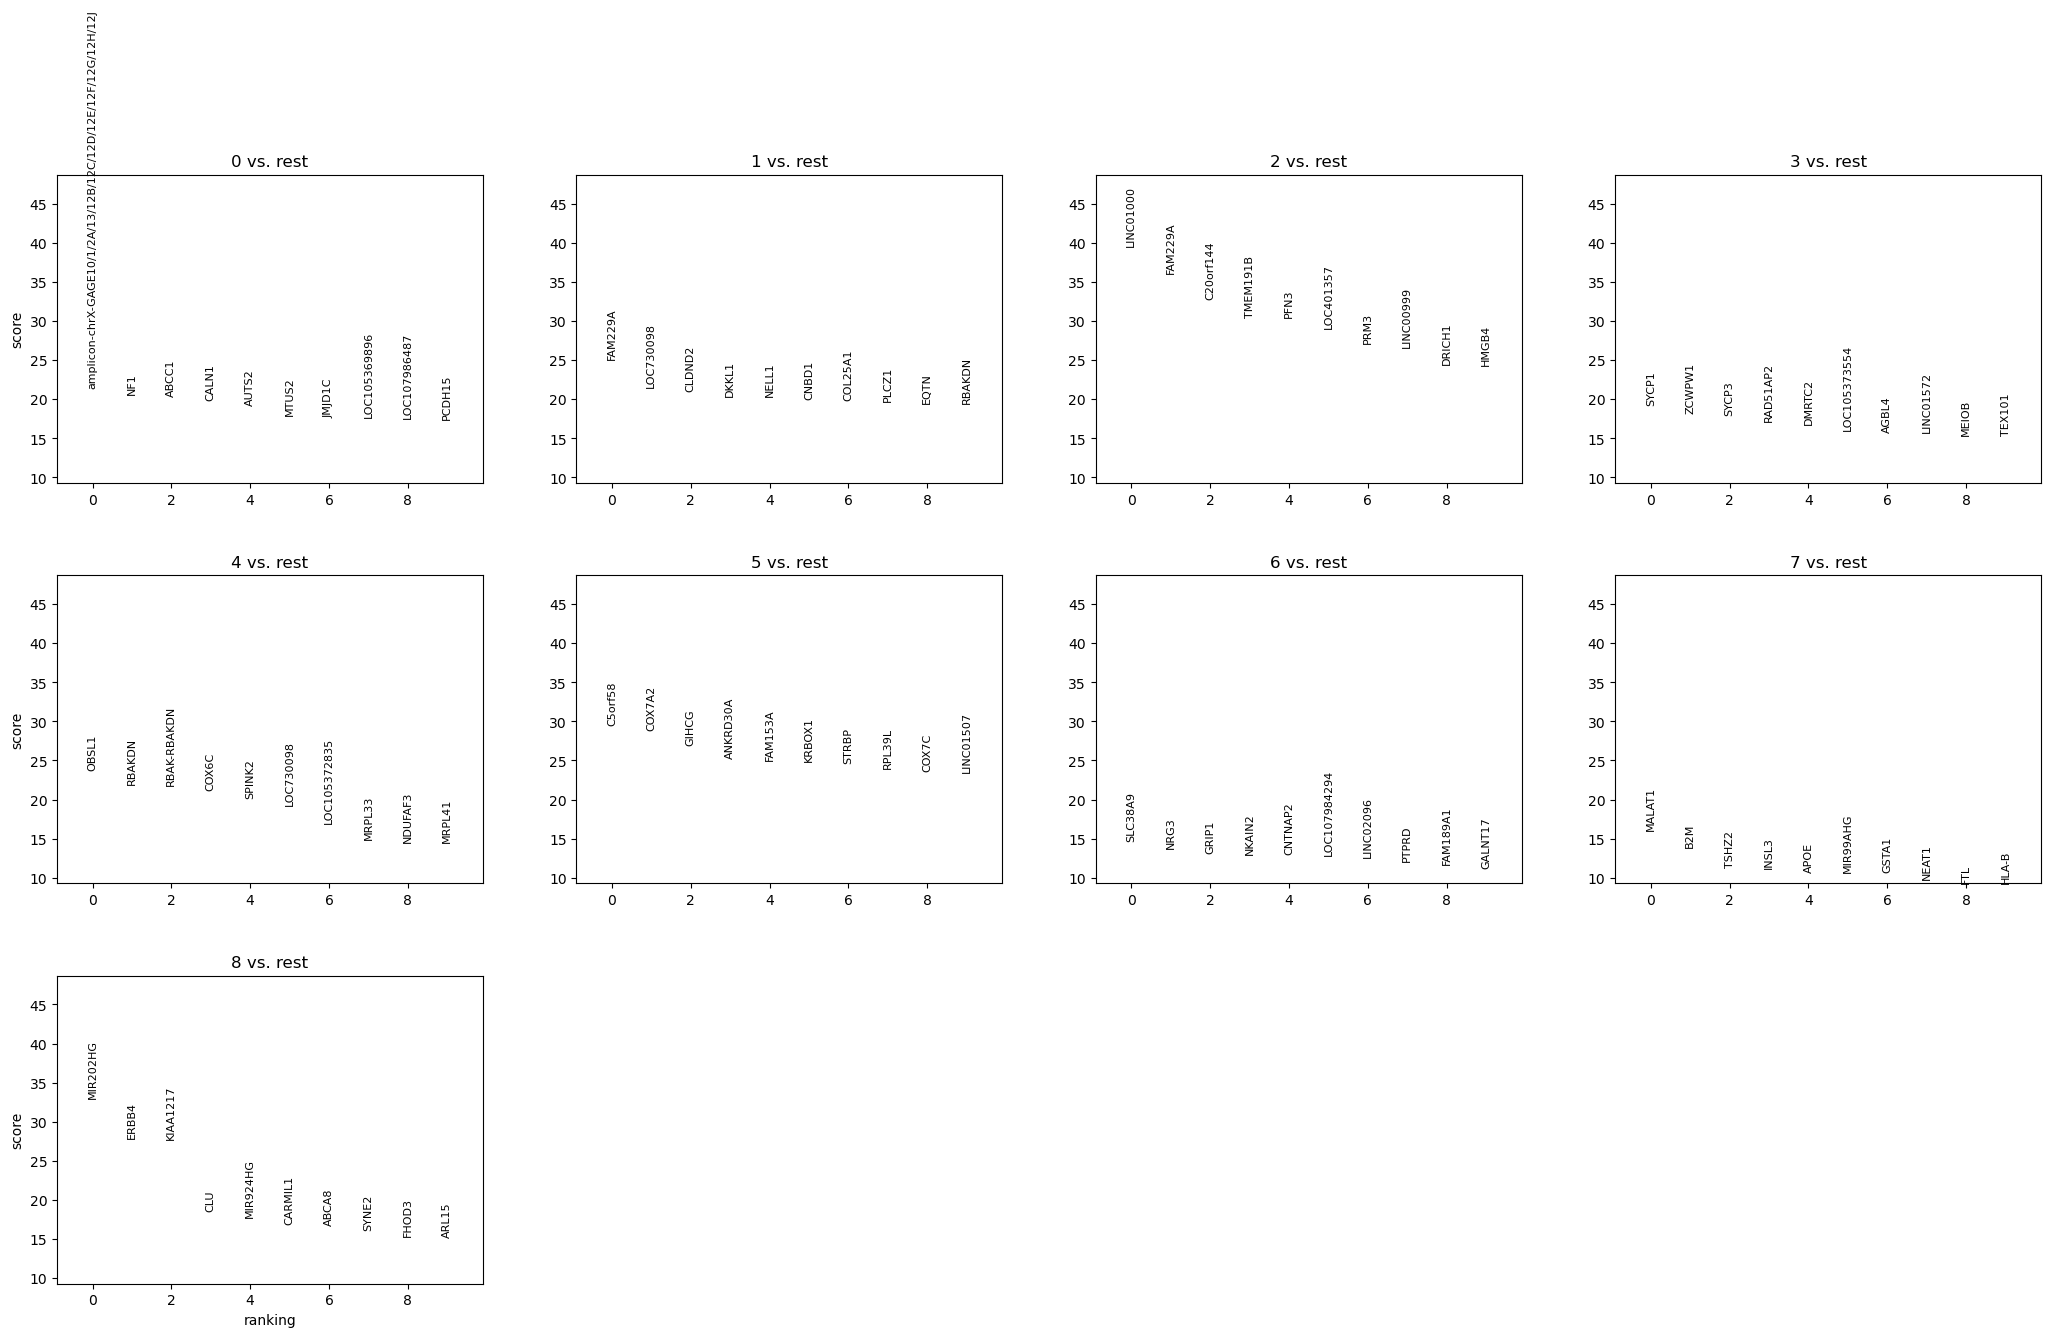

In [130]:
sc.pl.rank_genes_groups(adata, n_genes=10, groupby='leiden_R.5', key='DE_leiden') # sharey=False to change y axis to individual score

In [132]:
adata

AnnData object with n_obs × n_vars = 3772 × 22045
    obs: 'DATASET', 'batch', 'total_counts', 'n_genes_by_counts', 'percent_mito', 'prop_unspl', 'prop_spl', 'perc_MALAT1', 'n_genes', 'doublet_scores', 'predicted_doublets', 'Undif. SG_score', 'Dif. SG_score', 'SC.I_score', 'SC.II_score', 'Early round SD_score', 'Late round SD_score', 'Elong SD_score', 'Sertoli_score', 'Macroph_score', 'Leydig_score', 'Endothelial_score', 'leiden_R.3', 'leiden_R.2', 'leiden_R.1', 'leiden_R.5', 'leiden_R.4'
    var: 'gene_ids', 'feature_types', 'chromosome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'pca', 'DATASET_colors', 'hvg', 'neighbors', 'umap', 'leiden', 'leiden_R.3_colors', 'leiden_R.2_colors', 'leiden_R.1_colors', 'leiden_R.5_colors', 'leiden_R.4_colors', 'DE_leiden'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'raw_counts', 'spliced', 'unspliced', 'norm_sct', 'umi_corr'
    obsp: 'distances', 'connectivities'

Organize result in a table. Each column has the cluster numbers with _N, _P representing respectively the gene Names and their P-values change of each gene expression compared to the other clusters.

In [133]:
result = adata.uns['DE_leiden']
groups = result['names'].dtype.names
X = pd.DataFrame(
    {group + '_' + key[:1].upper(): result[key][group]
    for group in groups for key in ['names', 'pvals_adj']})
X.head() #print only first five lines

0_N           0_P        1_N  \
0  amplicon-chrX-GAGE10/1/2A/13/12B/12C/12D/12E/1...  5.013864e-82    FAM229A   
1                                                NF1  2.700399e-76  LOC730098   
2                                              ABCC1  3.245137e-74     CLDND2   
3                                              CALN1  6.604190e-72      DKKL1   
4                                              AUTS2  6.387295e-70      NELL1   

             1_P        2_N            2_P       3_N           3_P  \
0  9.224307e-102  LINC01000  5.670209e-172     SYCP1  6.244547e-59   
1   6.167361e-81    FAM229A  9.318227e-159    ZCWPW1  3.408901e-54   
2   8.972046e-73  C20orf144  3.388680e-137     SYCP3  4.216474e-53   
3   9.579188e-72   TMEM191B  2.532744e-123  RAD51AP2  2.012861e-49   
4   1.204708e-70       PFN3  7.170733e-122    DMRTC2  5.955663e-48   

           4_N           4_P       5_N           5_P      6_N           6_P  \
0        OBSL1  5.430176e-76   C5orf58  1.237656e-98  SLC38A9  8.129480e-37   
1       RBAKDN  1.045625e-69    COX7A2  1.292707e-94     NRG3  4.239395e-33   
2  RBAK-RBAKDN  1.045625e-69     GIHCG  4.658086e-87    GRIP1  1.196325e-30   
3        COX6C  3.022468e-65  ANKRD30A  1.278721e-81   NKAIN2  4.395617e-30   
4       SPINK2  2.190082e-61   FAM153A  2.818110e-79  CNTNAP2  3.658192e-30   

      7_N           7_P       8_N           8_P  
0  MALAT1  4.221460e-26  MIR202HG  5.748747e-35  
1     B2M  2.941243e-22     ERBB4  1.409333e-31  
2   TSHZ2  1.734043e-17  KIAA1217  2.412564e-31  
3   INSL3  2.631803e-17       CLU  2.396730e-23  
4    APOE  2.553220e-16  MIR924HG  1.674409e-22

In [134]:
pd.DataFrame(adata.uns['DE_leiden']['names']).head() # top 5 ranked genes for each cluster

0          1          2  \
0  amplicon-chrX-GAGE10/1/2A/13/12B/12C/12D/12E/1...    FAM229A  LINC01000   
1                                                NF1  LOC730098    FAM229A   
2                                              ABCC1     CLDND2  C20orf144   
3                                              CALN1      DKKL1   TMEM191B   
4                                              AUTS2      NELL1       PFN3   

          3            4         5        6       7         8  
0     SYCP1        OBSL1   C5orf58  SLC38A9  MALAT1  MIR202HG  
1    ZCWPW1       RBAKDN    COX7A2     NRG3     B2M     ERBB4  
2     SYCP3  RBAK-RBAKDN     GIHCG    GRIP1   TSHZ2  KIAA1217  
3  RAD51AP2        COX6C  ANKRD30A   NKAIN2   INSL3       CLU  
4    DMRTC2       SPINK2   FAM153A  CNTNAP2    APOE  MIR924HG

In [135]:
cd /home/astridkd/testis_singlecell/Workspaces/adahl/birc-project-akd/results

/faststorage/project/testis_singlecell/Workspaces/adahl/birc-project-akd/results


In [56]:
!mkdir -p cluster_results/GOR

In [136]:
X.to_csv('cluster_results/GOR/expr_annotation.csv', sep=',', index=None)

In [138]:
# cell type names for the chosen clusters

#new_names = {
#    '0':'SpermatogoniaA.1',
#    '1':'SpermatogoniaA.2',
#    '2':'Myoid',
#    '3':'Endothelial',
#    '4':'Leydig',
#    '5':'SpermatogoniaB',
#    '6':'Elong_Spermatids',
#    '7':'SpermatocitesII.1',
#    '8':'SpermatocitesII.2',
#    '9':'Round_Spermatids',
#    '10':'SpermatocitesI',
#    '11':'Macroph',
#    '12':'Pericytes'}


new_names = {
    '0':'Dif. SG',
    '1':'Late round SD',
    '2':'Elong. SD',
    '3':'SC.I',
    '4':'Early round SD',
    '5':'SC.II',
    '6':'Undif. SG',
    '7':'Macrophage',
    '8':'Sertoli'
}


We merge the clusters with same names. This cannot be done with a categorical object, where categories cannot have the same name. We convert the cluster names into a simple array to do this, and then reconvert it to a categorical object.

In [140]:
adata.obs['spermatogenesis_types'] = [new_names[x] for x in adata.obs['leiden_R.5'].tolist()]

In [143]:
palette_dict = {"Undif. SG":'lightblue',"Dif. SG":'blue',"SC.I":'lightgreen','SC.II':'green','Early round SD':'yellow','Late round SD':'orange','Elong. SD':'red','Sertoli':'pink','Macrophage':'brown'}

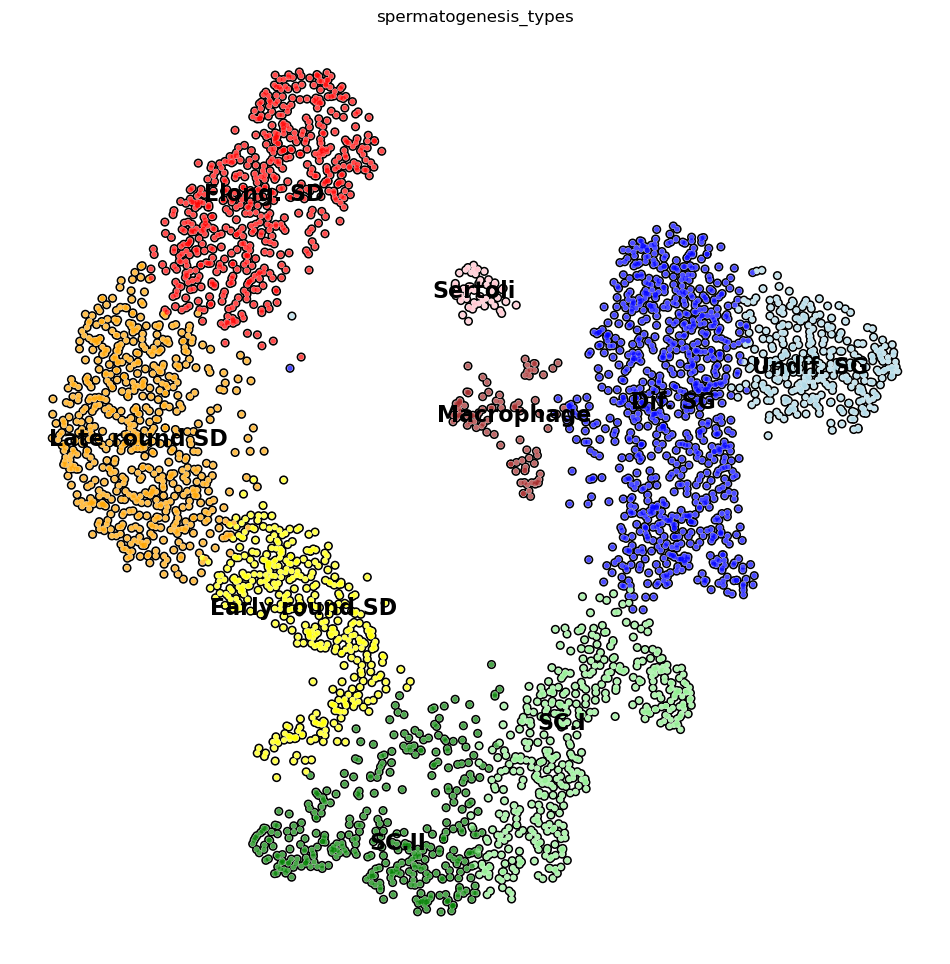

In [144]:
plt.rcParams['figure.figsize'] = (12,12)
sc.pl.umap( adata, color=['spermatogenesis_types'], 
           palette=palette_dict,
           legend_loc='on data', 
           legend_fontsize=16,
           frameon=False,
           size=60,
           add_outline=True,
           ncols=1  
           )

In [8]:
saved_adata = '/home/astridkd/testis_singlecell/Workspaces/adahl/birc-project-akd/results/cluster_results/GOR/cluster_adata.h5ad'
adata = sc.read(saved_adata)

In [145]:
adata

AnnData object with n_obs × n_vars = 3772 × 22045
    obs: 'DATASET', 'batch', 'total_counts', 'n_genes_by_counts', 'percent_mito', 'prop_unspl', 'prop_spl', 'perc_MALAT1', 'n_genes', 'doublet_scores', 'predicted_doublets', 'Undif. SG_score', 'Dif. SG_score', 'SC.I_score', 'SC.II_score', 'Early round SD_score', 'Late round SD_score', 'Elong SD_score', 'Sertoli_score', 'Macroph_score', 'Leydig_score', 'Endothelial_score', 'leiden_R.3', 'leiden_R.2', 'leiden_R.1', 'leiden_R.5', 'leiden_R.4', 'spermatogenesis_types'
    var: 'gene_ids', 'feature_types', 'chromosome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'pca', 'DATASET_colors', 'hvg', 'neighbors', 'umap', 'leiden', 'leiden_R.3_colors', 'leiden_R.2_colors', 'leiden_R.1_colors', 'leiden_R.5_colors', 'leiden_R.4_colors', 'DE_leiden', 'spermatogenesis_types_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'raw_counts', 'spliced', 'unspliced', 'norm_sct', 'umi_corr'
    obsp: 'distanc

In [146]:
sc.tl.rank_genes_groups(adata, groupby='spermatogenesis_types', n_genes=50, key_added='DE_leiden_celltype') # diff.expressed genes in each cluster (t-test)

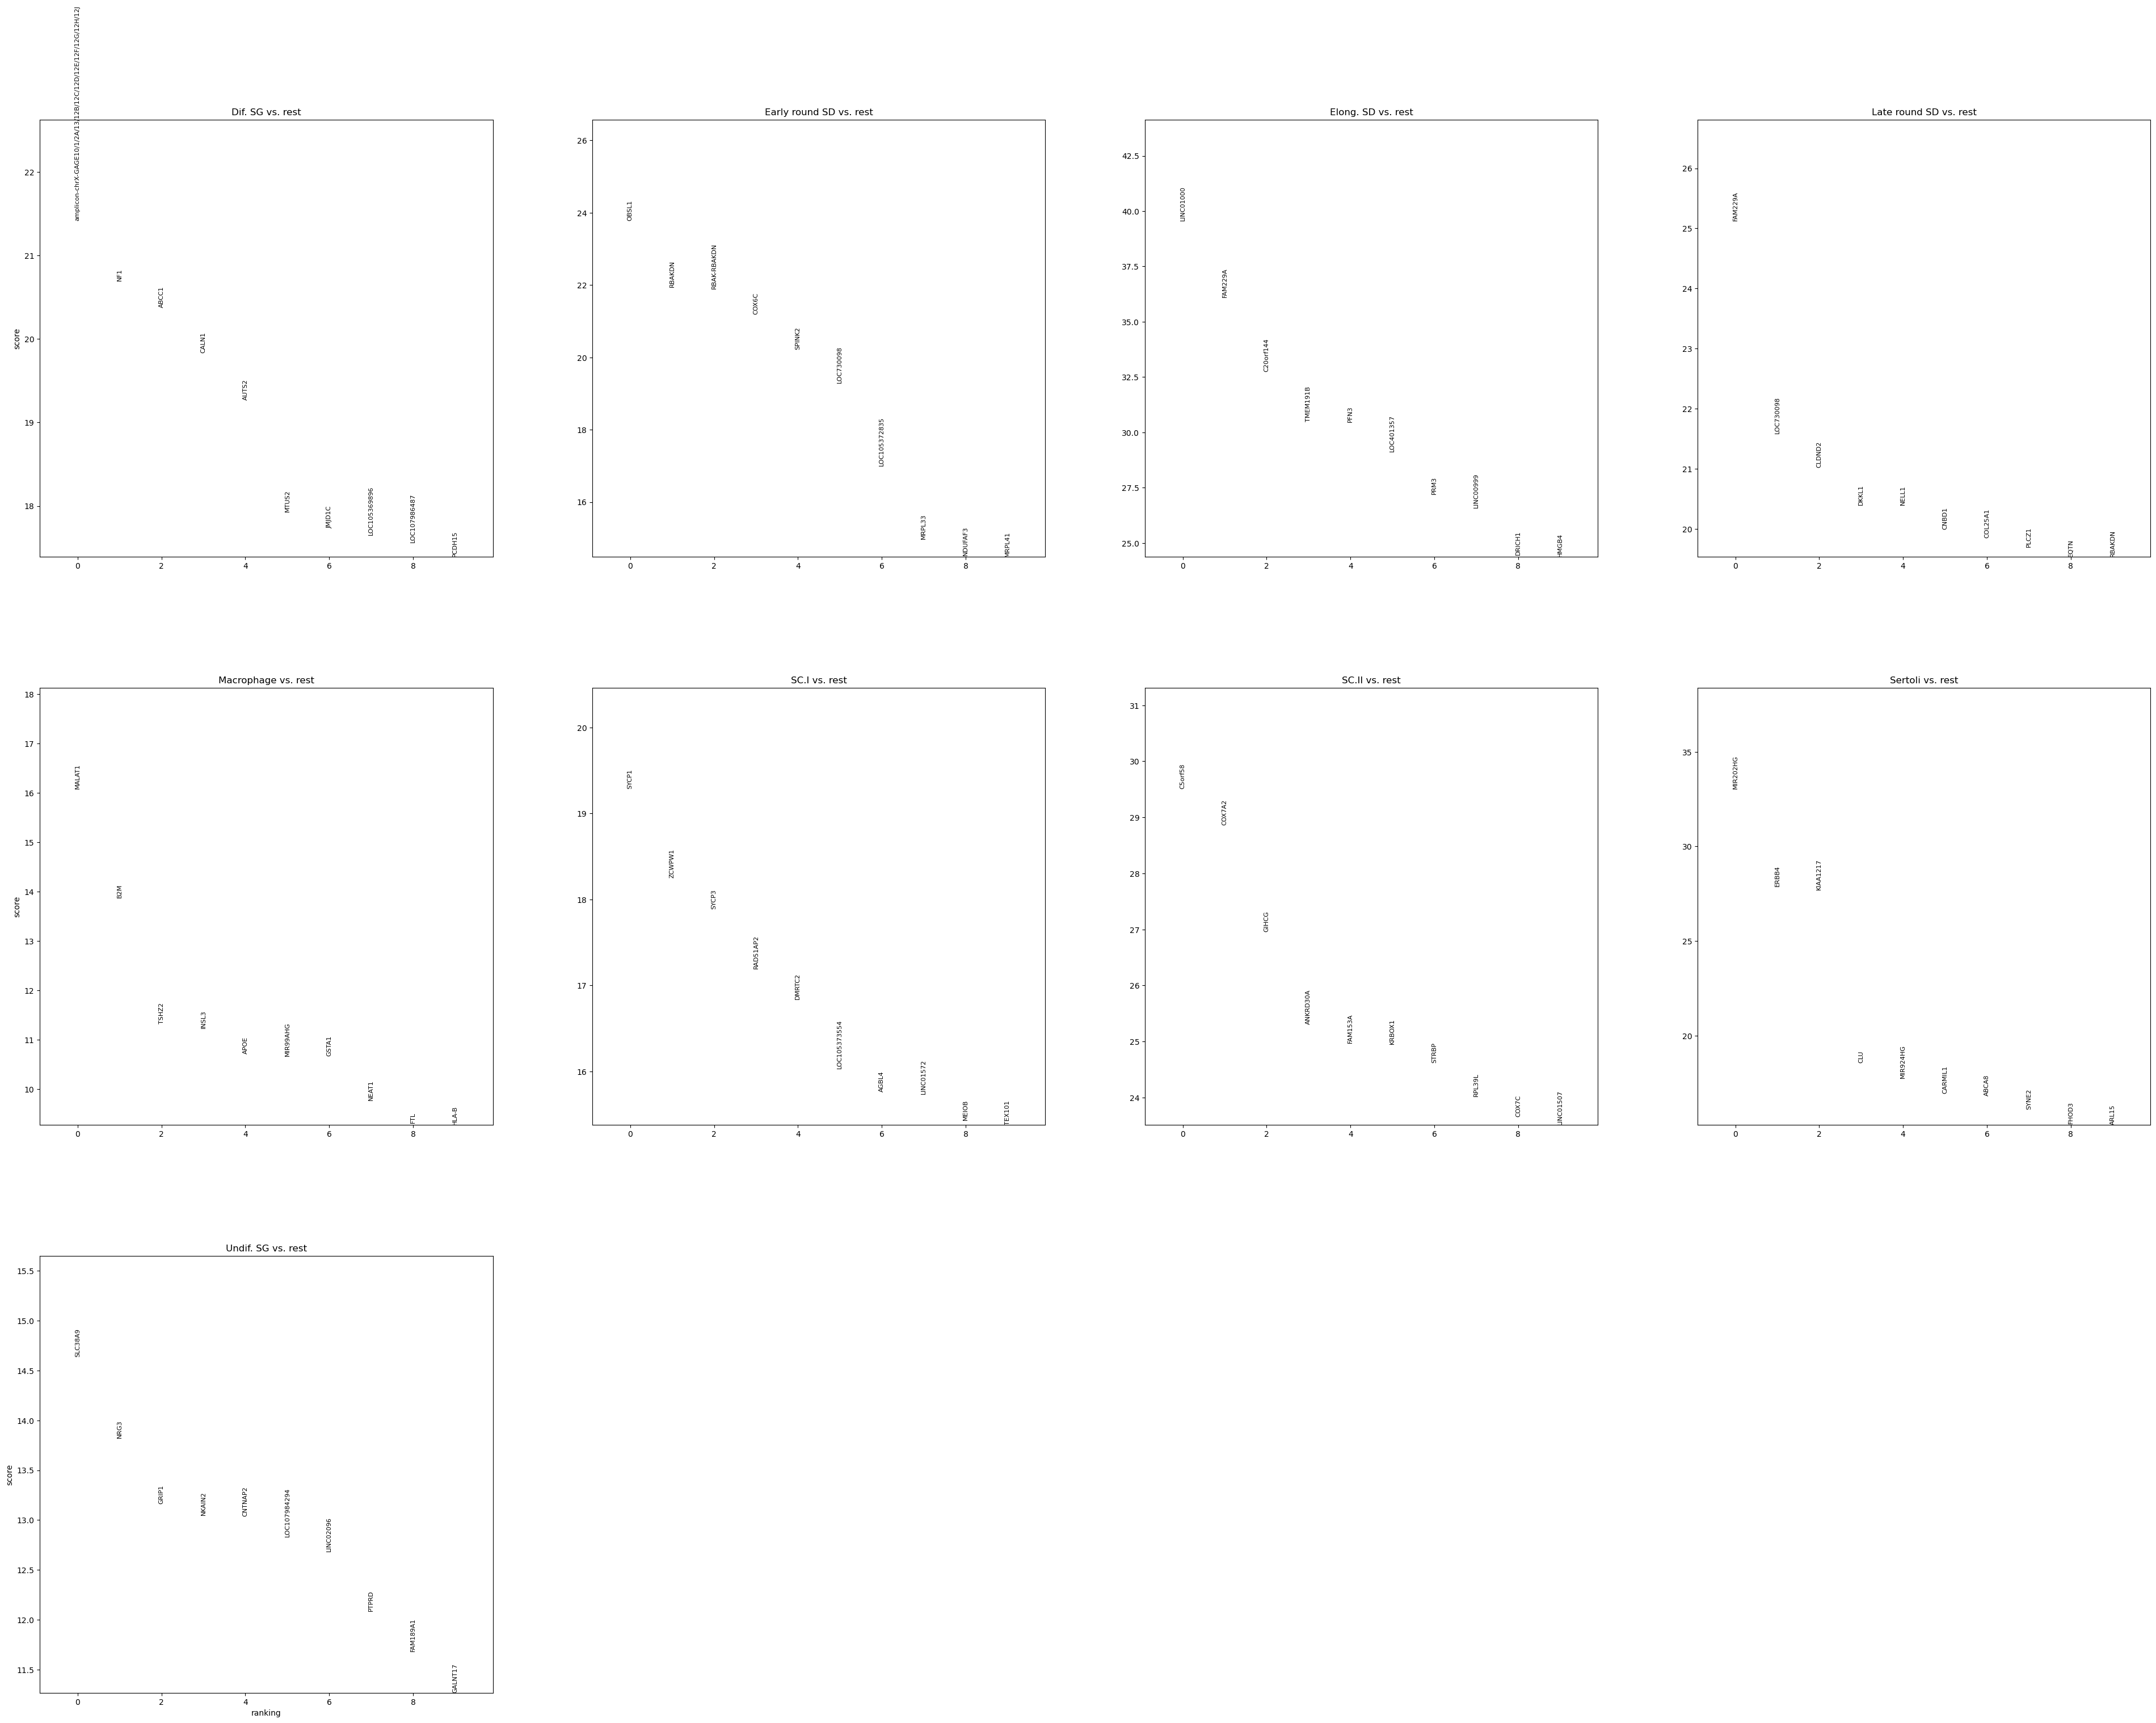

In [147]:
sc.pl.rank_genes_groups(adata, n_genes=10, groupby='spermatogenesis_types', key='DE_leiden_celltype', sharey=False) # sharey=False to change y axis to individual score

In [148]:
result2 = adata.uns['DE_leiden_celltype']
groups2 = result2['names'].dtype.names
X2 = pd.DataFrame(
    {group + '_' + key[:1].upper(): result2[key][group]
    for group in groups2 for key in ['names', 'pvals_adj']})
X2.head() #print only first five lines

Dif. SG_N     Dif. SG_P  \
0  amplicon-chrX-GAGE10/1/2A/13/12B/12C/12D/12E/1...  5.013864e-82   
1                                                NF1  2.700399e-76   
2                                              ABCC1  3.245137e-74   
3                                              CALN1  6.604190e-72   
4                                              AUTS2  6.387295e-70   

  Early round SD_N  Early round SD_P Elong. SD_N    Elong. SD_P  \
0            OBSL1      5.430176e-76   LINC01000  5.670209e-172   
1           RBAKDN      1.045625e-69     FAM229A  9.318227e-159   
2      RBAK-RBAKDN      1.045625e-69   C20orf144  3.388680e-137   
3            COX6C      3.022468e-65    TMEM191B  2.532744e-123   
4           SPINK2      2.190082e-61        PFN3  7.170733e-122   

  Late round SD_N  Late round SD_P Macrophage_N  Macrophage_P    SC.I_N  \
0         FAM229A    9.224307e-102       MALAT1  4.221460e-26     SYCP1   
1       LOC730098     6.167361e-81          B2M  2.941243e-22    ZCWPW1   
2          CLDND2     8.972046e-73        TSHZ2  1.734043e-17     SYCP3   
3           DKKL1     9.579188e-72        INSL3  2.631803e-17  RAD51AP2   
4           NELL1     1.204708e-70         APOE  2.553220e-16    DMRTC2   

         SC.I_P   SC.II_N       SC.II_P Sertoli_N     Sertoli_P Undif. SG_N  \
0  6.244547e-59   C5orf58  1.237656e-98  MIR202HG  5.748747e-35     SLC38A9   
1  3.408901e-54    COX7A2  1.292707e-94     ERBB4  1.409333e-31        NRG3   
2  4.216474e-53     GIHCG  4.658086e-87  KIAA1217  2.412564e-31       GRIP1   
3  2.012861e-49  ANKRD30A  1.278721e-81       CLU  2.396730e-23      NKAIN2   
4  5.955663e-48   FAM153A  2.818110e-79  MIR924HG  1.674409e-22     CNTNAP2   

    Undif. SG_P  
0  8.129480e-37  
1  4.239395e-33  
2  1.196325e-30  
3  4.395617e-30  
4  3.658192e-30

In [149]:
cd /home/astridkd/testis_singlecell/Workspaces/adahl/birc-project-akd/results

/faststorage/project/testis_singlecell/Workspaces/adahl/birc-project-akd/results


In [150]:
X2.to_csv('cluster_results/GOR/expr_annotation_celltype.csv', sep=',', index=None)

In [151]:
path_out = f'/home/astridkd/testis_singlecell/Workspaces/adahl/birc-project-akd/results/cluster_results/GOR'

if not os.path.exists(path_out):
    os.makedirs(path_out)

adata_out = f'{path_out}/cluster_adata.h5ad'

In [152]:
adata.write(adata_out)